* This is based on a tutorial of the TensorTrade library.
* TensorTrade is a framework for building, training, evaluating, and
deploying robust trading algorithms using reinforcement learning.

In [1]:
# based on https://github.com/tensortrade-org/tensortrade/blob/master/examples/train_and_evaluate.ipynb

* TensorTrade relies on existing tools such as OpenAI Gym, Keras, and TensorFlow to enable fast experimentation with algorithmic trading strategies.

In [2]:
pip install git+https://github.com/tensortrade-org/tensortrade.git

  Cloning https://github.com/tensortrade-org/tensortrade.git to /tmp/pip-req-build-kclbs_ar
  Running command git clone -q https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-kclbs_ar


In [3]:
# all imports:
import pandas as pd
import tensortrade.env.default as default

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent


%matplotlib inline

* Load a dataset of historical cryptocurrency prices.

In [4]:
cdd = CryptoDataDownload()

data = cdd.fetch("Bitstamp", "USD", "BTC", "1h")

* This dataset consists of hourly Bitcoin prices in US dollars. It looks like this.

In [5]:
data.head()

,date,unix,open,high,low,close,volume
0,2018-05-15 06:00:00,1526364000,8733.86,8796.68,8707.28,8740.99,559.93
1,2018-05-15 07:00:00,1526367600,8740.99,8766.00,8721.11,8739.00,273.58
2,2018-05-15 08:00:00,1526371200,8739.00,8750.27,8660.53,8728.49,917.79
3,2018-05-15 09:00:00,1526374800,8728.49,8754.40,8701.35,8708.32,182.62
4,2018-05-15 10:00:00,1526378400,8708.32,8865.00,8695.11,8795.90,1260.69


* Add a relative strength indicator signal, a technical indicator for the financial markets. 
* It measures the strength or weakness of a market by comparing the closing
prices of a recent trading period. 
* Add a moving average convergence/ divergence (MACD) indicator, which is designed to reveal changes in the strength, direction, momentum, and duration of a trend.

In [6]:
# we'll create a couple of indicators:
def rsi(price: Stream[float], period: float) -> Stream[float]:
    r = price.diff()
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)


def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal## Create features with the feed module

* Set up the feed that goes into decision making.
* Select the closing price as a feature.

In [7]:
# choosing the closing price:
features = []
for c in data.columns[1:]:
    s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
    features += [s]

cp = Stream.select(features, lambda s: s.name == "close")

* Add indicators as additional features.
* Aside from RSI and MACD, add a trend indicator (LR).

In [8]:
# adding the three features (trend indicator, RSI, MACD):
features = [
    cp.log().diff().rename("lr"),
    rsi(cp, period=20).rename("rsi"),
    macd(cp, fast=10, slow=50, signal=5).rename("macd")
]

feed = DataFeed(features)
feed.compile()

* Look at the first five lines from the data feed.

In [9]:
for i in range(5):
    print(feed.next())

{'lr': nan, 'rsi': nan, 'macd': 0.0}
{'lr': -0.00022768891842694927, 'rsi': 0.0, 'macd': -0.1891859774210995}
{'lr': -0.0012033785355889393, 'rsi': 0.0, 'macd': -1.2726616061000744}
{'lr': -0.0023134975946028646, 'rsi': 0.0, 'macd': -3.6577343503541435}
{'lr': 0.01000681330867259, 'rsi': 74.26253567956897, 'macd': 3.7087743627464844}


* Set up the broker.

In [10]:
# setting up broker and the portfolio:
bitstamp = Exchange("bitstamp", service=execute_order)(
    Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
)

portfolio = Portfolio(USD, [
    Wallet(bitstamp, 10000 * USD),
    Wallet(bitstamp, 10 * BTC)
])

* TensorTrade includes lots of monitoring tools, called renderers, which can be
attached to the environment.
* They can draw a chart (PlotlyTradingChart) or log to a
file (FileLogger).

In [11]:
# renderer:
renderer_feed = DataFeed([
    Stream.source(list(data["date"])).rename("date"),
    Stream.source(list(data["open"]), dtype="float").rename("open"),
    Stream.source(list(data["high"]), dtype="float").rename("high"),
    Stream.source(list(data["low"]), dtype="float").rename("low"),
    Stream.source(list(data["close"]), dtype="float").rename("close"), 
    Stream.source(list(data["volume"]), dtype="float").rename("volume") 
])

* Finally, here's the trading environment, which is an instance of the OpenAI Gym (the OpenAI Gym provides a wide variety of simulated environments).

In [12]:
# the trading environment:
env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=20
)

* Check the Gym feed.

In [13]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 8740.99,
  'bitstamp:/USD:/free': 10000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 10000.0,
  'bitstamp:/BTC:/free': 10.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 10.0,
  'bitstamp:/BTC:/worth': 87409.9,
  'net_worth': 97409.9},
 'external': {'lr': nan, 'rsi': nan, 'macd': 0.0},
 'renderer': {'date': Timestamp('2018-05-15 06:00:00'),
  'open': 8733.86,
  'high': 8796.68,
  'low': 8707.28,
  'close': 8740.99,
  'volume': 559.93}}

* This is what the trading bot will be able to rely on for making decisions on executing trades.

* Set up and train DQN trading agent.

In [14]:
# training a DQN trading agent
agent = DQNAgent(env)

agent.train(n_steps=200, n_episodes=2, save_path="agents/")

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, ..., 7911.83, 7901.01, 7887.  ]),
    …

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

-992650.6603905851

* This plot gives an overview of the market operations of our trading bot. 
* The first subplot shows the up and down movements of the prices. 
* Then the second subplot charts volumes of stock in the portfolio, and in the bottom-most subplot, see the portfolio net worth.

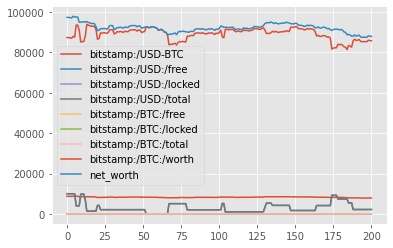

In [15]:
%matplotlib inline

performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.plot()

* See the portfolio net worth over time.

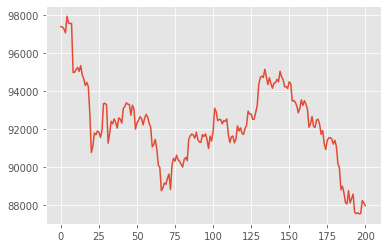

In [16]:
performance["net_worth"].plot()

* It looks like the trading bot could need some more training before getting let loose in the wild.